In [3]:
import numpy as np
import pandas as pd
from scipy.signal import find_peaks as findPeaks
from matplotlib import pyplot as plt
import os

os.getcwd()

'/Users/liming/projects/sensemaking/Day1'

In [50]:
ecg1D = pd.read_csv("ecg1D.csv", names=["value"], header=None, dtype="float32")
ecg1D.dtypes

value    float32
dtype: object

In [27]:
ecg1D["t"] = list(range(1, (ecg1D.shape[0]+1)))
ecg1D

,value,t
0,-0.570,1
1,-0.545,2
2,-0.535,3
3,-0.525,4
4,-0.545,5
...,...,...
1435,0.530,1436
1436,0.610,1437
1437,0.685,1438
1438,0.780,1439


[ 157  323  496  674  856 1048 1250]


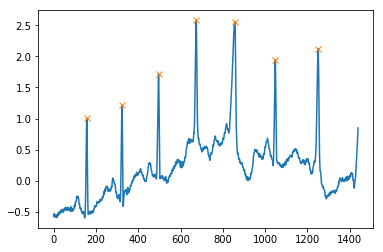

In [39]:
(allPks,_) = findPeaks(ecg1D.value, prominence=0.5)
print(allPks)

plt.figure()
plt.plot(ecg1D.value)
plt.plot(allPks, ecg1D.value[allPks], 'x')

In [49]:
ecg2D = pd.read_csv("ecg2D.csv", names=["y1", "y2", "y3"], header=None, dtype="float32")
ecg2D.dtypes

y1    float32
y2    float32
y3    float32
dtype: object

In [51]:
ecg2D.head(10)

,y1,y2,y3
0,0.065,0.725,-0.220
1,0.075,0.695,-0.225
2,0.080,0.670,-0.240
3,0.085,0.660,-0.245
4,0.085,0.655,-0.225
5,0.115,0.630,-0.215
6,0.170,0.615,-0.230
7,0.235,0.590,-0.245
8,0.265,0.565,-0.245
9,0.285,0.570,-0.215


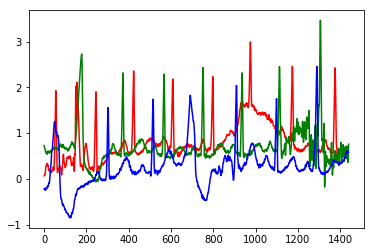

In [61]:
plt.figure()
plt.plot(ecg2D.y1, "red")
plt.plot(ecg2D.y2, "green")
plt.plot(ecg2D.y3, "blue")

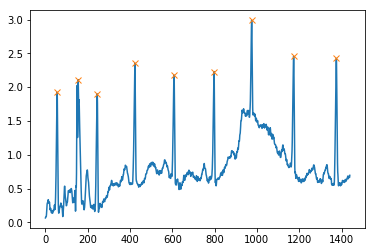

In [84]:
(peaks1,_) = findPeaks(ecg2D.y1, prominence=0.8)

plt.figure()
plt.plot(ecg2D.y1)
plt.plot(peaks1, ecg2D.y1[peaks1], 'x')

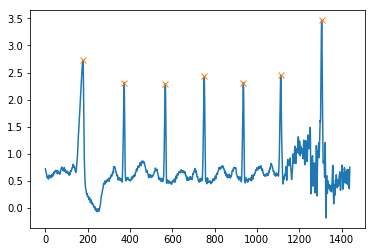

In [69]:
(peaks2,_) = findPeaks(ecg2D.y2, prominence=1.1)

plt.figure()
plt.plot(ecg2D.y2)
plt.plot(peaks2, ecg2D.y2[peaks2], 'x')

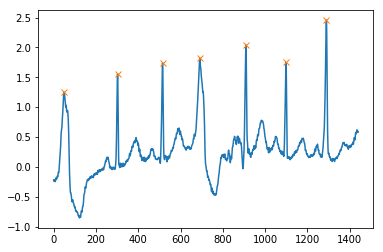

In [72]:
(peaks3,_) = findPeaks(ecg2D.y3, prominence=0.7)

plt.figure()
plt.plot(ecg2D.y3)
plt.plot(peaks3, ecg2D.y3[peaks3], 'x')

In [91]:
def extractECG(ecg, pks, offset=15):
    segments = [None]*(len(pks)-1)
    for i, pk in enumerate(pks[:len(segments)]):
        next_pk = pks[i+1]
        segments[i] = ecg[(pk+offset):(next_pk+offset)]
    return segments


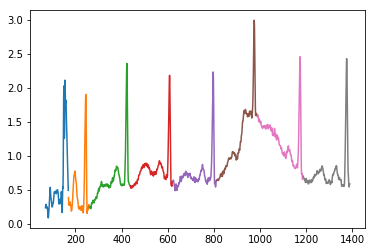

In [122]:
segments1 = extractECG(ecg2D.y1, peaks1)
plt.figure()
for seg in segments1:
    plt.plot(seg)

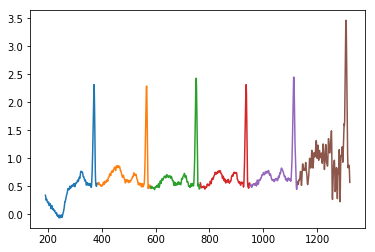

In [89]:
segments2 = extractECG(ecg2D.y2.values, peaks2)
plt.figure()
for seg in segments2:
    plt.plot(seg)

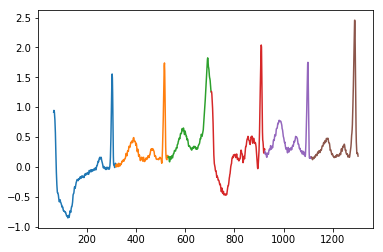

In [90]:
segments3 = extractECG(ecg2D.y3.values, peaks3)
plt.figure()
for seg in segments3:
    plt.plot(seg)

In [126]:
def get_dist(x, y):
    dists = np.zeros((len(y), len(x)))
    for i in range(len(y)):
        for j in range(len(x)):
            dists[i,j] = (y[i]-x[j])**2
    return dists

def get_accu_cost(seg1, seg2):
    dists = get_dist(seg1, seg2)
    acuCost = np.zeros(dists.shape)
    acuCost[0,0]= dists[0,0]
    for j in range(1,dists.shape[1]):
        acuCost[0,j] = dists[0,j]+acuCost[0,j-1]
    for i in range(1,dists.shape[0]):
        acuCost[i,0] = dists[i,0]+acuCost[i-1,0]
    for i in range(1,dists.shape[0]):
        for j in range(1,dists.shape[1]):
            acuCost[i,j] = min(acuCost[i-1,j-1], acuCost[i-1,j], acuCost[i,j-1])+dists[i,j]
    return acuCost

def get_path(acuCost, x, y):
    i = len(y)-1
    j = len(x)-1
    path = [[j,i]]
    while (i > 0) and (j > 0):
        if i==0:
            j = j-1
        elif j==0:
            i = i-1
        else:
            if acuCost[i-1,j] == min(acuCost[i-1,j-1], acuCost[i-1,j], acuCost[i,j-1]):
                i = i-1
            elif acuCost[i,j-1] == min(acuCost[i-1,j-1], acuCost[i-1,j], acuCost[i,j-1]):
                j = j-1
            else:
                i = i-1
                j = j-1
        path.append([j,i])
    path.append([0,0])
    return path

def pltDistances(dists,xlab="X",ylab="Y",clrmap="viridis"):
    imgplt = plt.figure()
    plt.imshow(dists, interpolation='nearest', cmap=clrmap)
    plt.gca().invert_yaxis()
    plt.xlabel(xlab)
    plt.ylabel(ylab)
    plt.grid()
    plt.colorbar()
    return imgplt

def pltCostAndPath(acuCost,path,xlab="X",ylab="Y",clrmap="viridis"):
    px = [pt[0] for pt in path]
    py = [pt[1] for pt in path]
    imgplt = pltDistances(acuCost,xlab=xlab,ylab=ylab,clrmap=clrmap)
    plt.plot(px,py)
    return imgplt


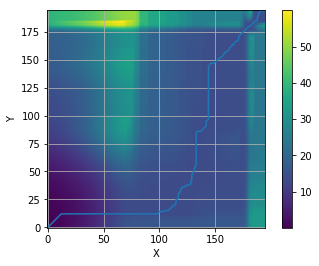

In [128]:
x, y = segments2[0].values, segments2[1].values
accu_cost = get_accu_cost(x, y)
path = get_path(accu_cost, x, y)
_ = pltCostAndPath(accu_cost, path)

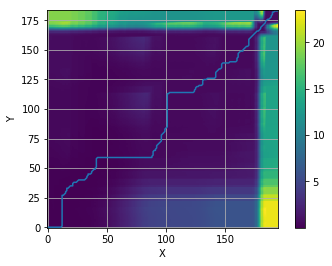

In [129]:
x, y = segments2[1].values, segments2[2].values
accu_cost = get_accu_cost(x, y)
path = get_path(accu_cost, x, y)
_ = pltCostAndPath(accu_cost, path)

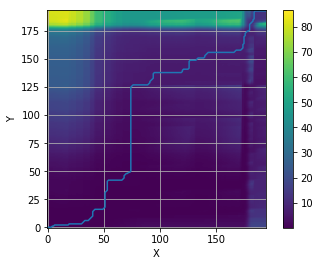

In [130]:
x, y = segments2[1].values, segments2[5].values
accu_cost = get_accu_cost(x, y)
path = get_path(accu_cost, x, y)
_ = pltCostAndPath(accu_cost, path)